# Homework 1: Algorithms for solving MDPs

It's worth outlining the goal of this homework. We've presented a bunch of algorithms but we haven't really made clear why they're useful or  tested your ability to implement them. This homework is designed to do both of those things.

## Problem 1: Value iteration in a tabular MDP
Lets do an example of the gambler's problem. This is example 4.3 in Sutton and Barto (with a tiny modification in that the game ends at 99 instead of 100. You can try the example after with 100 to see why it's a little trickier; in short, there isn't a unique optimal policy).
 
The gambler starts off with some money $s$ and can bet any amount of money up to the amount of money they have. 
If they win, they double the amount they bet (e.g. if they bet 40 and win, they now have 80). 
If they lose, they lose the amount they bet (e.g. if they have 60 and bet 40, now they have 20). 
The gambler wins if they reach 99 dollars, and los if they go broke.
The reward is 1 when they reach 99 and zero otherwise.

### Problem 1.1 - solving this with value iteration
Lets remind ourselves of our value iteration equation
$$V_{k+1}(s_i) = \max_{a} \sum_{s'} p(s'| s_i, a) [r(s_i,a,s') + \gamma V_k(s')]$$

where $p(s'| s, a)$ is the probability of transitioning to state $s'$ and receiving reward $r$ given that we are in state $s$ and take action $a$.

We usually run this until the maximum change in an iteration is smaller 
than some value $\epsilon$.

In [1]:
# imports used throughout this homework
from copy import copy
import random
import numpy as np
import matplotlib.pyplot as plt
from enum import Enum
import time
import gym

# Constants
P_HEADS = 0.4
DISCOUNT = 0.99
WIN_CONDITION = 99

## Some helpful utilities

In [ ]:

def transition(state, action, next_state):
    """You fill this in!"""
    assert action <= state, "You can't bet more money than you have"
    # the transition probability is zero unless we are winning the bet,
    # losing the bet, or doing nothing
    if next_state == state + action:
        return P_HEADS
    elif next_state == state - action:
        return 1 - P_HEADS
    elif next_state == state and action == 0:
        return 1
    else:
        return 0

## Desired outputs
To complete this problem please write code to plot the following things:
- The value function for states 1-99
- The maximum change in the value function for each iteration (over 32 iterations)
- The policy for states 1-99

I've precomputed the results so that you know it should look something like this

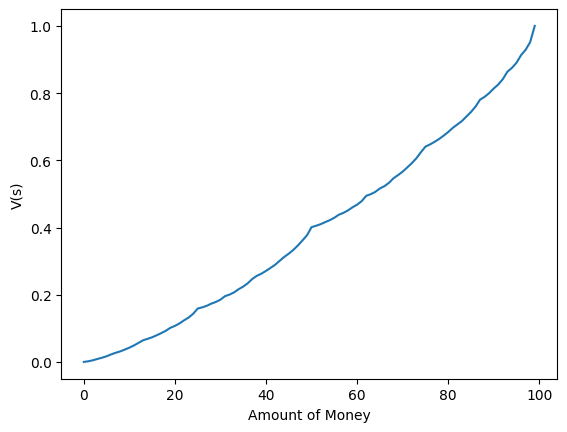
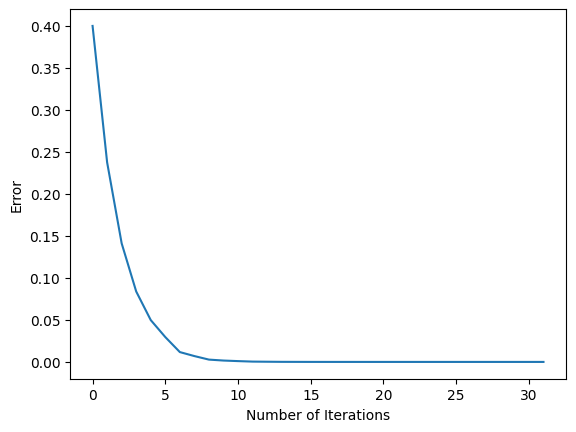
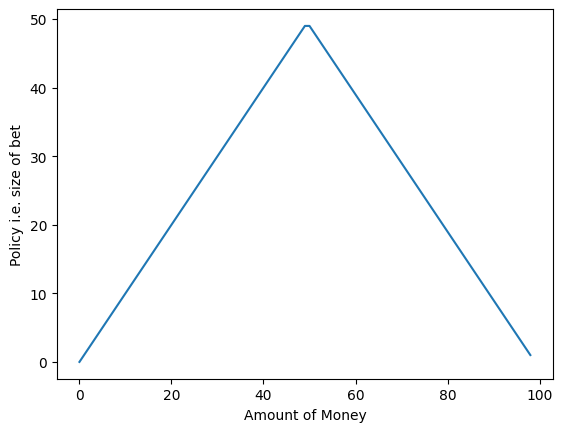

## Put your code and plots in the cell below

## Problem 1.2: little problem
Answer the following question in the cell below:
(1) We have a pop-up shop soap store that every-day can place an order to buy up to M units of soap. Each day, $p$ customers will come by and purchase the soap ($p < M$). The distribution from which $p$ is sampled is fixed but unknown. After a month, the shop will close down and the profit will be the number of units of soap sold. Answer the following questions:

(a) Formulate this problem as an MDP i.e. define the state space, action space, reward function, transition function, initial state distribution. There's some amount of freedom here so there might be multiple ways to define the MDP.  

(b) Is the optimal policy for this problem stationary?

(c) Why can this problem be formulated as an MDP even though there's an unknown quantity (i.e the distribution from which $p$ is drawn each day?)

# Problem 2: Value and policy iteration in a slightly more complicated
# MDP
For this second problem, you're basically going to be able to reuse the code that you've already written, but I want you to see that it's possible to use the same ideas to solve a more complicated problem.

As discussed in class, we have a two lane intersection controlled by a single traffic light. Traffic flows either South to North or East to West. At every tick, two cars will go through the intersection if the light is green in their direction (if there are fewer than two cars at the intersection, that number will go). After the cars go, with probability $p$ two cars will arrive at the north-south intersection and with probability $1-p$ they'll arrive at the west-east intersection. We receive a reward of +1 for the decrease in the queue size at each intersection.
Each intersection has a maximum queue length of $10$ cars. That is, if there are already $10$ cars in a given queue and another car arrives, the queue length will still be $10$. If a queue has more than $5$ cars, we receive a reward of -1 at each step. So, for example, if the north-south queue has length 6 and the east-west queue has length 4, we'll receive an additional reward of -1. If the north-south queue has length 6 and the east-west queue has length 6, we'll receive a reward of -2.
At each step, we can take an action to either set the traffic light to North or the traffic light to East. 

To make life easier, I've written up this environment for you. Note that in this environment, the state is $[q_0, q_1]$ where $q_0$ is the length of the north-south queue and $q_1$ is the east-west queue. Note that the traffic light direction is not a part of this state; make sure you understand why it isn't needed!`

In [ ]:
# some useful constants
NORTH_PROB = 0.7
GAMMA = 0.95
MAX_QUEUE_LENGTH = 10

# make everything deterministic
np.random.seed(0)
random.seed(0)

In [ ]:

    
class TrafficLightAction(Enum):
    NORTH = 0
    EAST = 1

class TrafficLightEnv():
    def __init__(self, ns_arrival_prob:float=0.75, max_queue_size:int=10):
        """Initializes the traffic light environment.
        
        Args:
            ns_arrival_prob: the probability of a car arriving from the north or south
            max_queue_size: the maximum number of cars that can be in each queue"""
        self.ns_arrival_prob = ns_arrival_prob
        self.max_queue_size = max_queue_size
        self.traffic_light_state = TrafficLightAction.NORTH.value
        
    def reset(self):
        """Resets the environment to its initial state."""
        return [0, 0]
        
    def step(self, state: np.array, action: int):
        """Takes a step in the environment.
        
        Args:
            state: the current state of the environment
            action: the action to take
        Returns: the new state and the reward"""
        old_state = copy(state)
        q_0, q_1 = state
    
        # Handle car departures based on the current direction
        if action == TrafficLightAction.NORTH.value:
            departed_cars = min(q_0, 2)
            q_0 = max(q_0 - departed_cars, 0)
        else:
            departed_cars = min(q_1, 2)
            q_1 = max(q_1 -departed_cars, 0)
                    
        # Handle car arrivals probabilistically
        if random.random() < self.ns_arrival_prob:
            if q_0 < self.max_queue_size: q_0 += 2
        else:
            if q_1 < self.max_queue_size: q_1 += 2
        
        # Update state after cars arrive
        new_state = np.array([q_0, q_1])
        reward = self.reward(old_state, new_state)
    
        return new_state, reward
        
    def reward(self, curr_state, next_state):
        """The reward is +1 for each departed car, -1 for each queue greater than 5"""
        north_reward = max(curr_state[0] - next_state[0], 0)
        east_reward = max(curr_state[1] - next_state[1], 0)
        north_penalty = -1 if next_state[0] > 5 else 0
        east_penalty = -1 if next_state[1] > 5 else 0
        return north_reward + east_reward + north_penalty + east_penalty
        
# here's a useful utility function
def evaluate_and_plot(policy, env: TrafficLightEnv, episode_length:int=100, should_plot=True):
    """Evaluates a policy and plots the results.
    
    Args:
        policy: the policy to evaluate. It should take in a 2-d state and
            return either a 0 or a 1.
        env: the environment to evaluate the policy on
        episode_length: the length of each episode
        
    Returns: the average reward for an episode
    """
    state = env.reset()
    states = np.zeros((episode_length, 2))
    tl_state = np.zeros(episode_length)
    rewards = np.zeros(episode_length)
    for t in range(episode_length):
        action = policy(state)
        assert (action == 0 or action == 1), "Policy should return 0 or 1"
        state, reward = env.step(state, action)
        states[t, 0] = state[0]
        states[t, 1] = state[1]
        tl_state[t] = action
        rewards[t] = (GAMMA**t) * reward
        
    # plot the queues on one plot and then the rewards on another
    # in a grid
    if should_plot:
        _, ax = plt.subplots(4, 1, figsize=(10, 10))
        ax[0].plot(states[:, 0])
        ax[0].set_xlabel('Time')
        ax[0].set_ylabel('North Queue')

        ax[1].plot(states[:, 1])
        ax[1].set_xlabel('Time')
        ax[1].set_ylabel('East Queue')
        # ax[0].legend(['Queue 0', 'Queue 1'])

        ax[2].plot(tl_state)
        ax[2].set_xlabel('Time')
        ax[2].set_ylabel('tl state')

        ax[3].plot(rewards.cumsum())
        ax[3].set_xlabel('Time')
        ax[3].set_ylabel('Discounted Reward')
        plt.show()
        print("total reward is ", rewards.sum())
    return rewards.sum()
        

In [ ]:
# Lets do a random rollout and visualize the length of each of the queues and the reward
# as a function of time

episode_length = 100
env = TrafficLightEnv(ns_arrival_prob=NORTH_PROB, max_queue_size=MAX_QUEUE_LENGTH)
evaluate_and_plot(lambda x: random.choice([0, 1]), env, episode_length=episode_length)


## Problem 2.1: Try to beat the random policy

In [ ]:
# write down a policy that you think is good here! 
def policy(state):
    """Fill in a better policy here"""
    return 0

evaluate_and_plot(policy, env, episode_length=100)

## Problem 2.2: Value iteration

Now lets solve the actual optimal policy using value iteration.

Now, it's pretty annoying to write out the transition probabilities and rewards for this problem, so I've approximately computed them for you below by rolling out the environment for a long time and computing the probability of transitioning from any state to any other state. 
Note that the format of the transition probabilities is as follows:
- The first index is the current north-south queue
- The second index is the current east-west queue
- The third index is the action
- The fourth index is the next state of the north-south queue
- The fifth index is the next state of the east-west queue

It's worth following through the details of what I did below but it's not essential. The important thing to know is that you can index into the matrix to compute the probability of starting with a queue size, taking an action, and transitioning to the new queue size.

In [ ]:
# the elements of the transition matrix are the probabilities of transitioning from one state to another
# the transition matrix is a 5-dimensional array, with the first 2 
# dimensions representing the current state
# the 3rd dimension representing the action
# and the last 2 dimensions representing the next state
transition_probs = np.zeros((MAX_QUEUE_LENGTH + 1, 
                             MAX_QUEUE_LENGTH + 1, 
                             2,
                             MAX_QUEUE_LENGTH + 1,
                             MAX_QUEUE_LENGTH + 1))
num_rollouts = 10000
env = TrafficLightEnv(ns_arrival_prob=NORTH_PROB, max_queue_size=MAX_QUEUE_LENGTH)
for i in range(num_rollouts):
    state = env.reset()
    for t in range(100):
        action = random.choice([0, 1])
        new_state, reward = env.step(state, action)
        transition_probs[state[0], state[1], action, 
                         new_state[0], new_state[1]] += 1
        state = new_state
# now we need to normalize the transition probabilities
# normally we would vectorize this but it's clearer to write it out
for q_0 in range(11):
    for q_1 in range(11):
        for action in range(2):
            if transition_probs[q_0, q_1, action].sum() > 0:
                transition_probs[q_0, q_1, action] /= transition_probs[q_0, q_1, action].sum()
                
# a few quick sanity checks to make sure we did the right thing
# first the probability of transitioning from [0, 0] to [0, 0] should be 0
# because a car should always arrive
assert transition_probs[0, 0, 0, 0, 0] == 0
# next, there should be APPROXIMATELY a NORTH_PROB of transitioning from 
# [0, 0] to [2, 0] regardless of the action
# and a 1 - NORTH_PROB probability of transitioning to [0, 2]
print('got ', transition_probs[0, 0, 0, 2, 0], 'expected ', NORTH_PROB)
print('got ', transition_probs[0, 0, 0, 0, 2], 'expected ', 1 - NORTH_PROB)
# finally, if the state is say, [4, 0] and the action is 0 then we should have
# NORTH_PROB probability of transitioning to [3, 0] and a 1 - NORTH_PROB probability
# of transitioning to [2, 1]
# and we can do something similar for the other action
print('got ', transition_probs[4, 0, 0, 4, 0], 'expected ', NORTH_PROB)
print('got ', transition_probs[4, 0, 0, 2, 2], 'expected ', 1 - NORTH_PROB)
print('got ', transition_probs[0, 4, 1, 2, 2], 'expected ', NORTH_PROB)
print('got ', transition_probs[0, 4, 1, 0, 4], 'expected ', 1 - NORTH_PROB)

In [ ]:
value_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
policy_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
epsilon = 0.0001

# PUT YOUR VALUE ITERATION CODE HERE TO UPDATE THE VALUE
# FUNCTION AND POLICY
# note that it will be helpful to use the reward function from the env
# so here's a helpful utility function
def reward(curr_state, next_state):
    return env.reward(curr_state, next_state)

# Also, please plot the size of the size of the maximum change of any entry
# in the value function array as a function of iteration number
def value_iteration(value_guess, policy_guess, transition_probs, reward, epsilon):
    """Fill in the value iteration algorithm here
    Args: 
        value_guess: the initial guess for the value function
        policy_guess: the initial guess for the policy
        transition_probs: the transition probabilities
        reward: the reward function
        epsilon: the stopping condition for value iteration
    Returns:
        value_guess: the final value function
        policy_guess: the final policy
        error_arr: the maximum change in the value function at each iteration
    """
    
    return [], [], []

t = time.time()
value_guess, policy_guess, error_arr = \
    value_iteration(value_guess, policy_guess, transition_probs, reward, epsilon)
print('total time it took to finish was ', time.time() - t)

plt.figure()
plt.plot(error_arr)

def policy_func(state):
    return policy_guess[state[0], state[1]]

# Lets compare how the episode actually went.
# Note that this is an expected reward, so it doesn't
# actually have to match except across many evals
# so we run it a bunch of times. They should match
# within about 0.1 of the expected reward from 
# the value function.
avg_reward = 0
num_iters = 500
for _ in range(num_iters):
    avg_reward += evaluate_and_plot(policy_func, env, episode_length=100, should_plot=False)
print('our achieved average reward is: ', avg_reward / num_iters)
print('while our expected reward was: ', value_guess[0, 0])

# lets also make some plots of the policy 
# and the value function. Do they make sense?

plt.figure()
plt.imshow(value_guess)
plt.colorbar()
plt.title('Value Function')
plt.xlabel('Queue 0')
plt.ylabel('Queue 1')

plt.figure()
plt.imshow(policy_guess)
plt.colorbar()
plt.title('Policy')
plt.xlabel('Queue 0')
plt.ylabel('Queue 1')

## Problem 2.3: Policy iteration
Repeat the above problem but use the policy iteration algorithm instead. Note that policy iteration uses value iteration in its inner loop so you can reuse your value iteration code. Try both timing the algorithm and computing the number of iterations!

In [ ]:
value_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
policy_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
epsilon = 0.001
def reward(curr_state, next_state):
    return env.reward(curr_state, next_state)

def policy_iteration(value_guess, policy_guess):
    """Fill in the policy iteration algorithm here
    Args: 
        value_guess: the initial guess for the value function
        policy_guess: the initial guess for the policy
    Returns:
        value_guess: the final value function
        policy_guess: the final policy
    """
    return value_guess, policy_guess

t = time.time()
value_guess, policy_guess = policy_iteration(value_guess, policy_guess)
print('total time it took was ', time.time() - t)
    
def policy_func(state):
    return policy_guess[state[0], state[1]]

avg_reward = 0
num_iters = 500
for _ in range(num_iters):
    avg_reward += evaluate_and_plot(policy_func, env, episode_length=100, should_plot=False)
print('our achieved average reward is: ', avg_reward / num_iters)
print('while our expected reward was: ', value_guess[0, 0])

# lets plot the policy function
plt.figure()
plt.imshow(policy_guess)
plt.colorbar()
plt.title('Policy')
plt.xlabel('Queue 0')
plt.ylabel('Queue 1')

## Problem 2.4 - Q-learning!
Okay, now we'll learn our first model-free reinforcement learning algorith. We'll use Q-learning to solve the same problem. Rather than requiring the explicit functional form of the transition probabilities, we can now just sample these transitions and environments from the environment! Lets write out the functional form of Q-learning. At each step we're going to sample a transition (s,a,r,s') from the environment. We'll then update our Q function using the following rule:
$Q(s,a) \leftarrow Q(s,a) + \alpha(r(s,a) + (1-\text{terminal})\max_{a'}Q(s', a') - Q(s,a))$. This term $1-\text{terminal}$ reflects the fact that if the episode is over there's no future reward after that point. It's not important in this problem since the episode never terminates but it'll be important later. 


Where do we get the action in the tuple from? We'll use an $\epsilon$-greedy policy. That is, with probability $\epsilon$ we'll take a random action and with probability $1-\epsilon$ we'll take the action that maximizes the Q function. Note that since our future actions are being taken under the argmax policy, this does not prevent us from learning the actual optimal policy.

However, unlike the prior algorithms it isn't clear when we should stop (well, you could track the change in the Q-function over the whole state space and stop once it stops changing too much). We'll just run this for a fixed number of iterations. You'll also find that the algorithm is quite sensitive to the learning rate $\alpha$ and the decay rate of $\epsilon$. You should experiment with these parameters to get the algorithm to work. However, do not be surprised if you are not fully able to match the performance of policy and value iteration. That's the price we pay for sampling instead of being able to compute things exactly!

In [ ]:
num_iters = None # YOU NEED TO PICK THIS NUMBER
q_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1, 2))

# I've picked an exploration strategy and learning rate strategy
# for you to make this problem a little more straightforward
# you can change these if you want.
def epsilon_greedy(q_guess, state, epsilon=0.05):
    """Use this to sample actions"""
    # TODO fill in the epsilon greedy strategy
    return 0
    
def epsilon(iter):
    """Use this to compute the value of epsilon at each iteration"""
    return 0.05

def learning_rate(alpha, iter):
    """Use this to compute the current value of alpha. Note that it satisfies
        the conditions on learning rates outlined in the lectures."""
    return alpha / ((iter + 1))

def q_learning(q_guess, num_iters, env, alpha=0.003):
    state = env.reset()
    for i in range(int(num_iters)):
        # why do we do this reset? Well, a totally random strategy tends to get stuck
        # in the state of (10, 10) where the queues are maximal and so to help with
        # exploration, we periodically reset the environment. This is a code level trick
        # there's technically nothing in Q-learning that requires this. The only thing
        # that matters algorithmically is that to guarantee convergence we need to ensure
        # that our exploration strategy eventually covers all (state, action) pairs.
        if i % 1000 == 0:
            state = env.reset()
        # FILL IN THE Q-FUNCTION UPDATE HERE
        pass
        
    return q_guess

t = time.time()
q_guess = q_learning(q_guess, num_iters, env)
print('total time it took was ', time.time() - t)
    
def policy_func(state):
    return np.argmax(q_guess[state[0], state[1]])

avg_reward = 0
num_iters = 500
for _ in range(num_iters):
    avg_reward += evaluate_and_plot(policy_func, env, episode_length=100, should_plot=False)
print('our achieved average reward is: ', avg_reward / num_iters)
print('while our expected reward was: ', value_guess[0, 0])

# lets plot the policy function by going through the q-function
# and computing the optimal action at each step
policy_guess = np.zeros((MAX_QUEUE_LENGTH + 1, MAX_QUEUE_LENGTH + 1))
# TODO fill in the policy guess from the Q function

plt.figure()
plt.imshow(policy_guess)
plt.colorbar()
plt.title('Policy')
plt.xlabel('Queue 0')
plt.ylabel('Queue 1')

# Problem 3: Going from tabular to function approximation
In the above problems, we've been able to compute the value function exactly. However, in many problems, the state space is too large to do this or we would like to do it without discretizing! We're going to show how moving from tabular methods to function approximation can be done and how it will enable us to solve some cute little problems and then also enable us to write a bot that plays flappy bird!

## Setting up the environment
To spare you some trouble, I've set up the flappy bird environment for you using some open-source code. The important thing to remember is that the environment has three methods that matter:
* env.reset(): sets the environment back to its initial state
* env.step(): takes an action and returns the next state, the reward, and whether the game is done
* env.render(): renders the environment

The state space used in this version of the game is 2-dimensional, representing the birds horizontal distance to the next pipe and its distance relative to the center of the vertical pipe.

In [102]:
from typing import Dict, Tuple, Optional, Union

import gym
import numpy as np
import pygame

from flappy_bird_gym.envs.game_logic import FlappyBirdLogic
from flappy_bird_gym.envs.game_logic import PIPE_WIDTH, PIPE_HEIGHT
from flappy_bird_gym.envs.game_logic import PLAYER_WIDTH, PLAYER_HEIGHT
from flappy_bird_gym.envs.renderer import FlappyBirdRenderer


class FlappyBirdEnvSimple(gym.Env):
    """ Flappy Bird Gym environment that yields simple observations.

    The observations yielded by this environment are simple numerical
    information about the game's state. Specifically, the observations are:

        * absolute y position of the player;
        * Difference between the player's y position and the next hole's y
          position.

    The reward received by the agent in each step is equal to the score obtained
    by the agent in that step. A score point is obtained every time the bird
    passes a pipe.

    Args:
        screen_size (Tuple[int, int]): The screen's width and height.
        normalize_obs (bool): If `True`, the observations will be normalized
            before being returned.
        pipe_gap (int): Space between a lower and an upper pipe.
        bird_color (str): Color of the flappy bird. The currently available
            colors are "yellow", "blue" and "red".
        pipe_color (str): Color of the pipes. The currently available colors are
            "green" and "red".
        background (Optional[str]): Type of background image. The currently
            available types are "day" and "night". If `None`, no background will
            be drawn.
    """

    metadata = {'render.modes': ['human']}

    def __init__(self,
                 screen_size: Tuple[int, int] = (288, 512),
                 normalize_obs: bool = True,
                 pipe_gap: int = 100,
                 bird_color: str = "yellow",
                 pipe_color: str = "green",
                 background: Optional[str] = "day",
                 frame_skip=3) -> None:
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(-np.inf, np.inf,
                                                shape=(2,),
                                                dtype=np.float32)
        self._screen_size = screen_size
        self._normalize_obs = normalize_obs
        self._pipe_gap = pipe_gap

        self._game = None
        self._renderer = None

        self._bird_color = bird_color
        self._pipe_color = pipe_color
        self._bg_type = background
        self._frame_skip = frame_skip

    def _get_observation(self):
        up_pipe = low_pipe = None
        h_dist = 0
        for up_pipe, low_pipe in zip(self._game.upper_pipes,
                                     self._game.lower_pipes):
            h_dist = (low_pipe["x"] + PIPE_WIDTH / 2
                      - (self._game.player_x - PLAYER_WIDTH / 2))
            h_dist += 3  # extra distance to compensate for the buggy hit-box
            if h_dist >= 0:
                break

        upper_pipe_y = up_pipe["y"] + PIPE_HEIGHT
        lower_pipe_y = low_pipe["y"]
        player_y = self._game.player_y

        v_dist = (upper_pipe_y + lower_pipe_y) / 2 - (player_y
                                                      + PLAYER_HEIGHT/2)

        if self._normalize_obs:
            h_dist /= self._screen_size[0]
            v_dist /= self._screen_size[1]

        return np.array([
            h_dist,
            v_dist,
        ])

    def step(self,
             action: Union[FlappyBirdLogic.Actions, int],
    ) -> Tuple[np.ndarray, float, bool, Dict]:
        """ Given an action, updates the game state.

        Args:
            action (Union[FlappyBirdLogic.Actions, int]): The action taken by
                the agent. Zero (0) means "do nothing" and one (1) means "flap".

        Returns:
            A tuple containing, respectively:

                * an observation (horizontal distance to the next pipe;
                  difference between the player's y position and the next hole's
                  y position);
                * a reward (always 1);
                * a status report (`True` if the game is over and `False`
                  otherwise);
                * an info dictionary.
        """
        alive = self._game.update_state(action)
        for _ in range(self._frame_skip - 1):
            alive = self._game.update_state(0)
        obs = self._get_observation()

        reward = (1 - (np.abs(obs[1]) / 5)) # reward is 1 for each frame the bird is alive

        done = not alive
        info = {"score": self._game.score}

        return obs, reward, done, info, {}

    def reset(self):
        """ Resets the environment (starts a new game). """
        self._game = FlappyBirdLogic(screen_size=self._screen_size,
                                     pipe_gap_size=self._pipe_gap)
        if self._renderer is not None:
            self._renderer.game = self._game

        return self._get_observation(), {}

    def render(self, mode='human') -> None:
        """ Renders the next frame. """
        if self._renderer is None:
            self._renderer = FlappyBirdRenderer(screen_size=self._screen_size,
                                                bird_color=self._bird_color,
                                                pipe_color=self._pipe_color,
                                                background=self._bg_type,
                                                audio_on=False)
            self._renderer.game = self._game
            self._renderer.make_display()

        self._renderer.draw_surface(show_score=True)
        self._renderer.update_display()

    def get_image(self):
      # Convert the Pygame surface to a NumPy array
      image_array = pygame.surfarray.array3d(self._renderer.surface)
      return image_array

    def close(self):
        """ Closes the environment. """
        if self._renderer is not None:
            pygame.display.quit()
            self._renderer = None
        super().close()

## The worlds fastest introduction to pytorch and neural networks
I highly recommend reading [https://pytorch.org/tutorials/beginner/basics/intro.html](Pytorch intro) but I've tried to reproduce its absolutely most succinct form below.

You can think of pytorch as numpy plus auto-differentiation. What this means is that if I have a parametrized function $f_\theta$ and a loss function $L(f_\theta)$ (often just written as $L(\theta)$), I can compute the gradient of the loss with respect to $\theta$. This allows me to do gradient descent on $\theta$ to minimize the loss and find a good set of parameters $\theta$. We're going to use this to implement a simple neural network version of Q-learning. 

The important things to know about pytorch are the following:
(1) Optimizers: torch comes with a bunch of built in optimizers. These will compute the gradients of the loss with respect to the parameters and update the parameters. We'll use the Adam optimizer in this problem. Optimizers are instantiated with respect to a particular model. It then tracks every transformation of the model and can update the parameters. For example, to create an optimizer for a model you would write
```python
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
```
If we then form a loss using the model output in some way, we can then compute the gradients of the loss with respect to the model parameters and update the model parameters using the following code:
```python
loss = some_loss_function(model(data), target)
optimizer.zero_grad() # <-this is used to zero out prior gradients that may have accumulated.
loss.backward()
optimizer.step()
```
For example, if we inexplicably wanted to learn a neural network function that mapped all data to the number two, we could write the following code:
```python
import torch
import torch.nn as nn
import torch.optim as optim
data = torch.randn(10, 5)
target = torch.ones(10, 1) * 2
model = nn.Linear(5, 1)
optimizer = optim.Adam(model.parameters(), lr=0.01)
for i in range(100):
    optimizer.zero_grad()
    loss = nn.MSELoss()(model(data), target)
    loss.backward()
    optimizer.step()
```

(2) Tensors: instead of arrays like numpy, pytorch uses tensors. The important difference is that tensors will have a .grad attribute that tracks the gradient of the loss with respect to the tensor.

(3) Neural networks: pytorch comes with a bunch of built in neural network layers. For example, to create a simple neural network that takes in 5 inputs, has 3 hidden units, and outputs 1 value, you would write
```python
model = nn.Sequential(
    nn.Linear(5, 3),
    nn.ReLU(),
    nn.Linear(3, 1)
)
```
The nn.Sequential thing takes in a list of neural network components and composes them into a model that can be used like a function. The first linear layer takes in 5 inputs and outputs 3 values. The ReLU layer applies the rectified linear unit function to each of the 3 values. The second linear layer takes in 3 values and outputs 1 value. Pytorch will figure out how to compute the gradients of the loss with respect to the parameters of this model and update them using the optimizer.

In this homework I'm going to write the neural network for you just to make this a bit easier. However, in future homework assignments this is going to be something you do youself.


In [103]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F


# set up a three layer neural network with 64 hidden units at each layer
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, seed, hidden_size=64):
        super(QNetwork, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, state):
        x = F.relu(self.fc1(state))
        x = F.relu(self.fc2(x))
        return self.fc3(x)


## Why does this matter?
Well, what we're going to do is use the neural network as our policy. It's going to take in a ste and output a distribution over actions. We'll then sample from this distribution to get our action. We'll then use the Q-learning update rule to update the Q function. Soon as we stick a neural network into it, this becomes what's called "Deep-Q learning" (though in practice, there are some additional tricks people use that we're glossing over in this homework and will add in later.)

The procedure is as follows: 
(1) We'll sample a batch of transitions of size B from the environment
(2) We form the loss by computing the mean squared error between the Q function and the target Q function. The target Q function is computed using the Q-learning update rule but with the Q function replaced by the neural network. One important thing to note, the target is meant to be a fixed scalar that is *not differentiated through*. To accomplish this, you can make it so that a value is not differentiated through by calling .detach() on it or wrapping the function evaluation in a
`with torch.no_grad():` block. 
To repeat, **MAKE SURE YOU CALL DETACH ON THE TARGET**. It's a super common bug.

(3) We'll then compute the gradients of the loss with respect to the parameters of the neural network and update the parameters using the optimizer.

## Replay Buffer
One other common trick that we'll use is to stick every acquired sample into a buffer and then draw samples from it at every time we take a training step. This is useful because this way when we see an important sample we can use it to update the Q function multiple times. This is called "experience replay". Additionally, it also breaks the temporal correlation between samples which can make learning more stable.

## Debugging tips
1. You may want to try this on a simpler problem first. For example, you could replace the call to make the env with `env = gym.make("CartPole-v1")` and then replace the state and action spaces with the appropriate sizes. This will allow you to debug your code faster. In general, try to write the code so it is agnostic to the size of the state and action space.
2. Check your Q-function estimates for some representative states. Are they close to the average reward that you get from that state? If not, there could be something off about your hyperparameters. If the estimates are way too small, try running for more steps or a larger learning rate. If they're too large, try running a smaller learning rate!

In [104]:
class ReplayBuffer():
    def __init__(self, buffer_size=1000):
        self.buffer_size = buffer_size
        self.buffer = None # TODO create a buffer class
        
    def add(self, state, action, reward, done, next_state):
        """Add a new experience to the buffer. Pop oldest experience if buffer is full."""
        pass
        
    def sample(self, batch_size=32):
        """Return a batch_size number of samples from the buffer"""
        pass
    
    def __len__(self):
        return len(self.buffer)
    
class DQN():
    def __init__(self, state_space=3, action_space=2, buffer_size=100000, batch_size=512, 
                 gamma=0.99, lr=1e-3, init_epsilon=0.1, final_epsilon=0.01, anneal_rate=3e5):
        self.q_function = QNetwork(state_space, action_space, 0)
        self.optimizer = optim.Adam(self.q_function.parameters(), lr=lr)
        self.buffer = ReplayBuffer(buffer_size)
        self.batch_size = batch_size
        self.init_epsilon = init_epsilon
        self.final_epsilon = final_epsilon
        self.anneal_rate = anneal_rate
        self.gamma = gamma
        self.action_list = [i for i in range(action_space)]
        self.step_counter = 0
        
    def epsilon_greedy(self):
        slope = (self.final_epsilon - self.init_epsilon) / self.anneal_rate
        eps = max(slope * self.step_counter + self.init_epsilon, self.final_epsilon)
        return eps
        
    def act(self, state, random_action=True):
        self.step_counter += 1
        if random.random() < self.epsilon_greedy() and random_action:
            return random.choice(self.action_list)
        else:
            return torch.argmax(self.q_function(torch.tensor(state, dtype=torch.float32))).item()
        
    def learn(self):
        if len(self.buffer) < self.batch_size:
            return
        batch = self.buffer.sample(self.batch_size)
        state, action, reward, done, next_state = zip(*batch)
        state = torch.tensor(state, dtype=torch.float32)
        action = torch.tensor(action, dtype=torch.int64)
        reward = torch.tensor(reward, dtype=torch.float32)
        done = torch.tensor(done, dtype=torch.float32)
        next_state = torch.tensor(next_state, dtype=torch.float32)
        q_values = self.q_function(state)
        next_q_values = self.q_function(next_state)
        target_q_values = reward + (1 - done) * self.gamma * torch.max(next_q_values, dim=1)[0]
        loss = F.mse_loss(q_values.gather(1, action.view(-1, 1)), target_q_values.view(-1, 1).detach())
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()
        return loss.item()
    
    def add(self, state, action, reward, done, next_state):
        self.buffer.add(state, action, reward, done, next_state)
        
    def __len__(self):
        return len(self.buffer)

In [113]:
num_iters = int(2e6)
batch_size = 512
GAMMA = 0.99
initial_lr = 5e-5
# TODO(ev) have only managed to make it work with frame_skip=3
env = FlappyBirdEnvSimple(frame_skip=2)
# env = gym.make('MountainCar-v0')
state, _ = env.reset()
action_size = env.action_space.n
state_size = len(state)
agent = DQN(state_space=state_size, action_space=action_size, 
            buffer_size=50000, batch_size=batch_size, gamma=GAMMA, lr=initial_lr)
observed_reward = 0
total_episodes = 0
episode_length = 0
average_rew = []
avg_episode_len = []
for i in range(num_iters):
    # FILL IN THE Q-NETWORK UPDATE HERE
    action = agent.act(state)
    next_state, reward, done, _, _ = env.step(action)
    agent.add(state, action, reward, done, next_state)
    observed_reward += reward
    agent.learn()
    state = next_state
    episode_length += 1
    if done or episode_length > 500:
        print('iter ', i, 'episode ', total_episodes, 'average reward of past 100 episodes is ', np.mean(average_rew[-100:]))
        print('avg episode length is ', np.mean(avg_episode_len[-100:]))
        average_rew.append(observed_reward)
        avg_episode_len.append(episode_length)
        total_episodes += 1
        observed_reward = 0
        episode_length = 0
        state, _ = env.reset()

# plot the smoothed reward with a window of 100
plt.figure()
plt.plot(np.convolve(average_rew, np.ones(100) / 100, mode='valid'))

# plot the smoothed episode_length with a window of 100
plt.figure()
plt.plot(np.convolve(avg_episode_len, np.ones(100) / 100, mode='valid'))

iter  23 episode  0 average reward of past 100 episodes is  nan
avg episode length is  nan
iter  61 episode  1 average reward of past 100 episodes is  23.49278125
avg episode length is  24.0
iter  110 episode  2 average reward of past 100 episodes is  30.026671874999998
avg episode length is  31.0
iter  126 episode  3 average reward of past 100 episodes is  36.115375
avg episode length is  37.0
iter  142 episode  4 average reward of past 100 episodes is  30.916269531250002
avg episode length is  31.75
iter  168 episode  5 average reward of past 100 episodes is  27.8638375
avg episode length is  28.6
iter  200 episode  6 average reward of past 100 episodes is  27.437054687499998
avg episode length is  28.166666666666668
iter  242 episode  7 average reward of past 100 episodes is  27.98377232142857
avg episode length is  28.714285714285715
iter  268 episode  8 average reward of past 100 episodes is  29.528794921875
avg episode length is  30.375
iter  284 episode  9 average reward of past

KeyboardInterrupt: 

In [116]:
obs, _ = env.reset()
i = 0
total_reward = 0
imgs = []
states = []
# os.environ["SDL_VIDEODRIVER"] = "dummy"
while True:
    # Next action:
    # get the action from the q-network
    action = agent.act(obs, random_action=False)
    print(action)

    # Processing:
    next_obs, reward, done, info, _ = env.step(action)
    total_reward += reward
    obs = next_obs
    # print(obs, i)
    # the observation is the normalized horizontal and vertical distance to the next pipe
    
    # Rendering the game:
    # (remove these two lines during training)
    if hasattr(env, 'get_image'):
        env.render()
        imgs.append(env.get_image().transpose((1, 0, 2)))
    states.append(next_obs)
    time.sleep(1 / 30)  # FPS
    
    # Checking if the player is still alive
    if done or i == 500:
        break
    i += 1

print('total reward is ', total_reward)
env.close()

%matplotlib inline
from matplotlib import pyplot as plt
from matplotlib import animation
from IPython.display import HTML

# np array with shape (frames, height, width, channels)
fig = plt.figure()
im = plt.imshow(imgs[0])

plt.close() # this is required to not display the generated image

def init():
    im.set_data(imgs[0])

def animate(i):
    im.set_data(imgs[i])
    return im

anim = animation.FuncAnimation(fig, animate, init_func=init, frames=len(imgs),
                               interval=50)
HTML(anim.to_html5_video())

1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
1
1
1
1
1
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
0
0
0
0
0
0
0
0
1
0
1
1
1
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0
0
0
0
0
0
0
1
0
0
0
0
0
0
0


In [67]:
agent.q_function(torch.tensor([-0.5, 0]).float().unsqueeze(0))

tensor([[-89.7903, -89.7341, -89.8979]], grad_fn=<AddmmBackward0>)

In [66]:
print(state)

[-0.5305888  0.0005554]
